In [85]:
%matplotlib inline
import matplotlib.pyplot as plt
PLOT_CONFIG = { 'interpolation': "nearest", 'aspect': "auto", 'cmap': "Greys" }

from IPython.display import Audio

import soundfile as sf
import numpy as np

from numpy.fft import fft, ifft
from scipy.fftpack import dct, idct

from collections import defaultdict
from copy import deepcopy
from glob import glob
from scipy.spatial.distance import cdist

# Part 1: Feature extraction (Mel-Frequency Cepstral Coefficients)
-------------------------------------------------
- Explore the feature extraction pipeline

### TODO:
-----------
- <strong>Finish the implementation of the 'discrete_fourier_transform' and compare the runtime speed with the 'fast_fourier_transform'.</strong>
- <strong> Convert the yticks on plots from indices to frequencies or mels where specified by <em>TODO</em>.</strong>
- Generate MFCCs and recover the orginal audio with the default settings (after implementing the DFT) by executing the cells below.
- Play with the different settings of <em>size</em> (window size), <em>step</em> (window shift), <em>nfilters</em> (the number of filters in the mel-filterbank), and <em>ncoeffs</em> (the number of mel-frequency cepstral coefficients that are kept after feature extraction). Note that the process for inversion can be fragile, so it is best to try powers of 2 (e.g. <em>size</em> = [64, 128, 256, 512, 1024, ...] and <em>step</em> = [8, 16, 32, 64, 128, ...]).

In [4]:
def pre_emphasis(x):
    """
    Applies pre-emphasis step to the signal.
    - balance frequencies in spectrum by increasing amplitude of high frequency 
    bands and decreasing the amplitudes of lower bands
    - largely unnecessary in modern feature extraction pipelines
    ------
    :in:
    x, array of samples
    ------
    :out:
    y, array of samples
    """
    y = np.append(x[0], x[1:] - 0.97 * x[:-1])
    
    return y
    
def hamming(n):
    """
    Hamming method for weighting components of window.
    Feel free to implement more window functions.
    ------
    :in: 
    n, window size
    ------
    :out: 
    win, array of weights to apply along window
    """
    win = 0.54 - .46 * np.cos(2 * np.pi * np.arange(n) / (n - 1))
    
    return win
    
def windowing(x, size, step):
    """
    Window and stack signal into overlapping frames.
    ------
    :in:
    x, array of samples
    size, window size in number of samples (Note: this may need to be a power of 2)
    step, window shift in number of samples
    ------
    :out:
    frames, 2d-array of frames with shape (number of windows, window size)
    """
    xpad = np.append(x, np.zeros((size - len(x) % size)))
    
    T = (len(xpad) - size) // step
    frames = np.stack([xpad[t * step:t * step + size] for t in range(T)])
    
    ##print(frames)
    
    return frames
    
def discrete_fourier_transform(x):
    """
    Compute the discrete fourier transform for each frame of windowed signal x.
    Typically, we talk about performing the DFT on short-time windows
    (often referred to as the Short-Time Fourier Transform). Here, the input
    is a 2d-array with shape (window size,  number of windows). We want to
    perform the DFT on each of these windows.
    Note: this can be done in a vectorized form or in a loop.
    --------
    :in: 
    x, 2d-array of frames with shape (window size, number of windows)
    --------
    :out:
    X, 2d-array of complex spectrum after DFT applied to each window of x
    """
    
    # TODO: Implement DFT
    window_size = len(x)
    rotation = []
    for index in range(window_size):
        for k in range(window_size):
            rotation.append(np.exp(-2j*np.pi*index*k/window_size))

    rotation = np.reshape(rotation,(window_size,window_size))
    X = rotation@x

    return X

    
def fast_fourier_transform(x):
    """
    Fast-fourier transform. Effiicient algorithm for computing the DFT.
    --------
    :in: 
    x, 2d-array of frames with shape (window size, number of windows)
    --------
    :out:
    X, 2d-array of complex spectrum after DFT applied to each window of x
    """
    fft_size = len(x)

    if fft_size <= 16:
        X = discrete_fourier_transform(x)
    
    else:
        indices = np.arange(fft_size)
        even = fast_fourier_transform(x[::2])
        odd = fast_fourier_transform(x[1::2])
        m = np.exp(-2j * np.pi * indices / fft_size).reshape(-1, 1)
        X = np.concatenate([even + m[:fft_size // 2] * odd, even + m[fft_size // 2:] * odd])
    
    return X


def mel_filterbank(nfilters, fft_size, sample_rate):
    """
    Mel-warping filterbank.
    You do not need to edit this code; it is needed to contruct the mel filterbank
    which we will use to extract features.
    --------
    :in: 
    nfilters, number of filters
    fft_size, window size over which fft is performed
    sample_rate, sampling rate of signal
    --------
    :out:
    mel_filter, 2d-array of (fft_size / 2, nfilters) used to get mel features
    mel_inv_filter, 2d-array of (nfilters, fft_size / 2) used to invert
    melpoints, 1d-array of frequencies converted to mel-scale
    """
    freq2mel = lambda f: 2595. * np.log10(1 + f / 700.)
    mel2freq = lambda m: 700. * (10**(m / 2595.) - 1)

    lowfreq = 0
    highfreq = sample_rate // 2

    lowmel = freq2mel(lowfreq)
    highmel = freq2mel(highfreq)

    melpoints = np.linspace(lowmel, highmel, 1 + nfilters + 1)

    # must convert from freq to fft bin number
    fft_bins = ((fft_size + 1) * mel2freq(melpoints) // sample_rate).astype(np.int32)

    filterbank = np.zeros((nfilters, fft_size // 2))
    for j in range(nfilters):
        for i in range(fft_bins[j], fft_bins[j + 1]):
            filterbank[j, i] = (i - fft_bins[j]) / (fft_bins[j + 1] - fft_bins[j])
        for i in range(fft_bins[j + 1], fft_bins[j + 2]):
            filterbank[j, i] = (fft_bins[j + 2] - i) / (fft_bins[j + 2] - fft_bins[j + 1])

    mel_filter = filterbank.T / filterbank.sum(axis=1).clip(1e-16)
    mel_inv_filter = filterbank

    return mel_filter, mel_inv_filter, melpoints
    
    
def inv_spectrogram(X_s, size, step, n_iter=15):
    """
    Feel free to disregard this code. It is not necessary that
    you follow the code below, but it can be used to invert
    from the spectrogram (signal spectrum magnitude) back to the signal
    which can be helpful when qualitatively assessing the nature of
    compression into MFCC features.
    """
    
    def find_offset(a, b):
        corrs = np.convolve(a - a.mean(), b[::-1] - b.mean())
        corrs[:len(b) // 2] = -1e12
        corrs[-len(b) // 2:] = -1e12
        return corrs.argmax() - len(a)

    def iterate(X, iteration):
        T, n = X.shape
        size = n // 2

        x = np.zeros((T * step + size))
        window_sum = np.zeros((T * step + size))

        est_start = size // 2 - 1
        est_stop = est_start + size

        for t in range(T):
            x_start = t * step
            x_stop = x_start + size

            est = ifft(X[t].real + 0j if iteration == 0 else X[t]).real[::-1]            
            if t > 0 and x_stop - step > x_start and est_stop - step > est_start:
                offset = find_offset(x[x_start:x_stop - step], est[est_start:est_stop - step])
            else:
                offset = 0
                
            x[x_start:x_stop] += est[est_start - offset:est_stop - offset] * hamming(size)
            window_sum[x_start:x_stop] += hamming(size)

        return x.real / window_sum.clip(1e-12)

    X_s = np.concatenate([X_s, X_s[:, ::-1]], axis=1)
    reg = np.max(X_s) / 1e8

    X_best = iterate(deepcopy(X_s), 0)
    for i in range(1, n_iter):
        X_best = windowing(X_best, size, step) * hamming(size)
        est = fast_fourier_transform(X_best.T).T
        phase = est / np.maximum(reg, np.abs(est))
        X_best = iterate(X_s * phase[:len(X_s)], i)
    
    return np.real(X_best)

In [5]:
# original signal
signal, fs = sf.read('aurora_FMS_15739A.wav')
Audio(data=signal, rate=fs)

In [10]:
# pre-emphasized signal
Audio(data=pre_emphasis(signal), rate=fs)

[0.00100708 0.00100708 0.00024414 ... 0.00064087 0.00064087 0.00048828]


In [32]:
# test the runtime of your discrete fourier transform against the fast fourier transform

# with a window size of 128 and a step of 32
frames128 = windowing(signal, 128, 64) * hamming(128)
%timeit -n 50 discrete_fourier_transform(frames128.T).T
%timeit -n 50 fast_fourier_transform(frames128.T).T

# check that the discrete_fourier_transform is correct
# NOTE: the difference in shape (transpose or not transpose) between our implementation and numpy's
print("Is DFT correct?", np.allclose(fft(frames128), discrete_fourier_transform(frames128.T).T, atol=1e-12))
print("Is FFT correct?", np.allclose(fft(frames128), fast_fourier_transform(frames128.T).T, atol=1e-12))

# with a window size of 512 and a step of 32
frames512 = windowing(signal, 512, 256) * hamming(512)
%timeit -n 50 discrete_fourier_transform(frames512.T).T
%timeit -n 50 fast_fourier_transform(frames512.T).T

# with a window size of 2048 and a step of 32
frames2048 = windowing(signal, 2048, 1024) * hamming(2048)
%timeit -n 50 discrete_fourier_transform(frames2048.T).T
%timeit -n 50 fast_fourier_transform(frames2048.T).T

28.3 ms ± 1.41 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)
4.3 ms ± 242 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)
Is DFT correct? True
Is FFT correct? True
404 ms ± 10.6 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)
17.3 ms ± 579 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)
6.02 s ± 75.4 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)
54.2 ms ± 992 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [92]:
size = 128 # window size for the FFT
step = size // 2 # distance to slide along the window in time
nfilters = 26 # number of mel frequency channels
ncoeffs = 13 # number of cepstral coeffecients to keep

# pre-emphasize signal
pre_emphasized_signal = pre_emphasis(signal)

# window signal
frames = windowing(pre_emphasized_signal, size, step) * hamming(size)

# compute complex spectrum
spectrum = fast_fourier_transform(frames.T).T
spectrum = spectrum[:, :size // 2] # only need to keep half since it's symmetric

# compute spectrum magnitude (typically what is meant by spectrogram)
magnitude = np.abs(spectrum)

# get spectrum power
power = magnitude**2 / size

([<matplotlib.axis.YTick at 0x296095a24a8>,
 <a list of 7 Text yticklabel objects>)

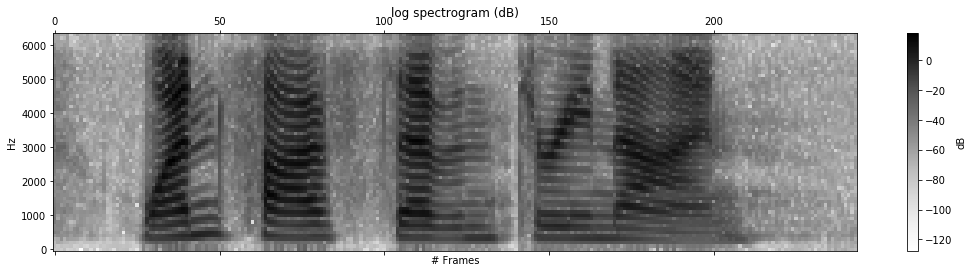

In [93]:
# Visualize log spectrogram (dB)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,4))
cax = ax.matshow(20*np.log10(magnitude.clip(1e-12)).T, origin='lower', **PLOT_CONFIG)
fig.colorbar(cax, label='dB')
plt.title('log spectrogram (dB)')
plt.xlabel('# Frames')
plt.ylabel('Indices')

# TODO: yticks as frequencies
# ----------------------------
frequencies = np.arange(0,8000,1000)
indices = np.arange(0,70,10)
plt.ylabel('Hz')
plt.yticks(indices, frequencies)

In [94]:
# Generate the mel filter and mel inverse filter
mel_filter, mel_inv_filter, melpoints = mel_filterbank(nfilters, size, fs)

Text(0.5, 1.05, 'mel filter')

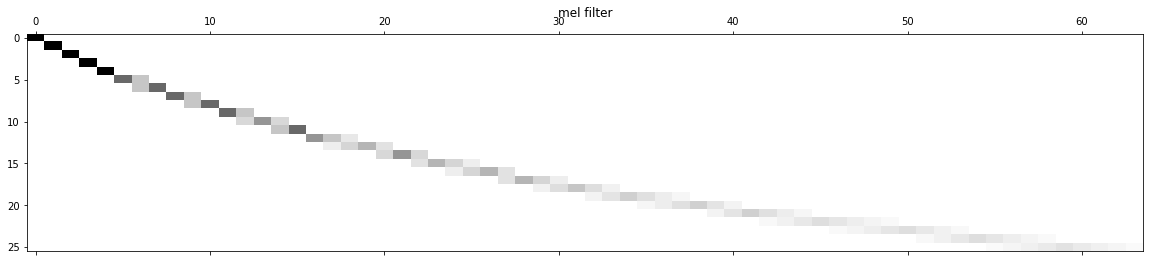

In [95]:
# Look at the mel filter
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
ax.matshow(mel_filter.T, **PLOT_CONFIG)
ax.set_title('mel filter')

([<matplotlib.axis.YTick at 0x29609a6af60>,
 <a list of 3 Text yticklabel objects>)

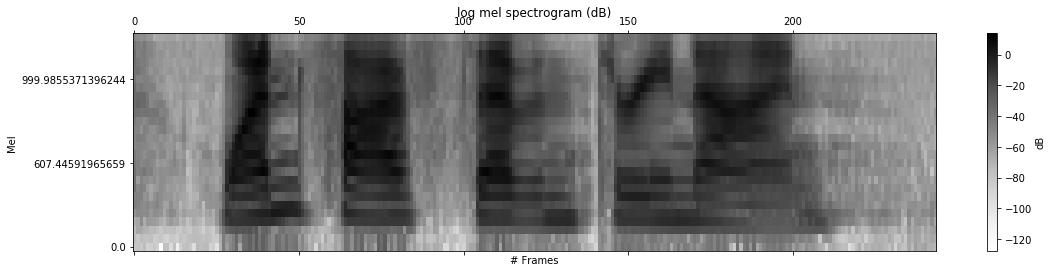

In [96]:
# Visualize log mel spectrogram (dB) (Note: striations corresponding to filters with 0 above)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,4))
cax = ax.matshow(20*np.log10(magnitude.dot(mel_filter).clip(1e-16)).T, origin='lower', **PLOT_CONFIG)
fig.colorbar(cax, label='dB')
plt.title('log mel spectrogram (dB)')
plt.xlabel('# Frames')
plt.ylabel('Indices (Filter #)')

# TODO: yticks as mels
# ----------------------------
indices = np.arange(0,30,10)
frequencies = np.arange(0,4000,500)
freq2mel = lambda f: 2595. * np.log10(1 + f / 700.)
mels = freq2mel(frequencies)
plt.ylabel('Mel')
plt.yticks(indices, mels)

Text(0.5, 1.05, 'MFCCs')

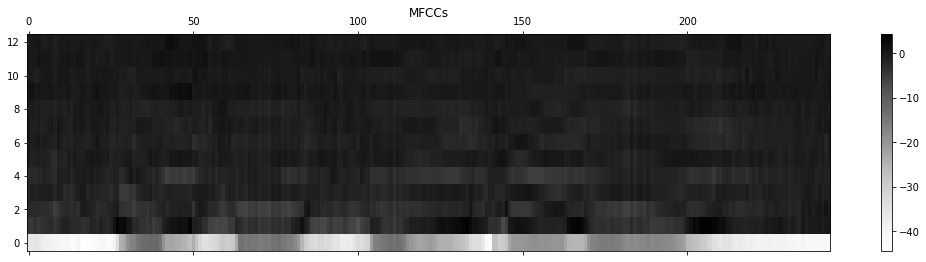

In [97]:
# apply mel warping filters to power spectrum and take log10
log_mel_fbank = np.log10(power.dot(mel_filter).clip(1e-16))

# compute MFCCs using discrete cosine transform
"""
Note: DCT is used to decompose a finite discrete-time vector
into a sum of scaled-and-shifted (real-valued) cosine functions
(this can be thought of similarly to the DFT); additionally,
the DCT often has better compression qualities as its top coefficients
tend to by largely decorrelated, which can improve our position when
make modeling assumptions later on
"""
mfccs = dct(log_mel_fbank, type=2, axis=1, norm='ortho')

# keep subset of cepstral coefficients
mfccs = mfccs[:,:ncoeffs]

# Visualize (normalized) MFCCs
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,4))
cax = ax.matshow(mfccs.T, origin='lower', **PLOT_CONFIG)
fig.colorbar(cax)
plt.title('MFCCs')

([<matplotlib.axis.YTick at 0x29609bb05f8>,
 <a list of 3 Text yticklabel objects>)

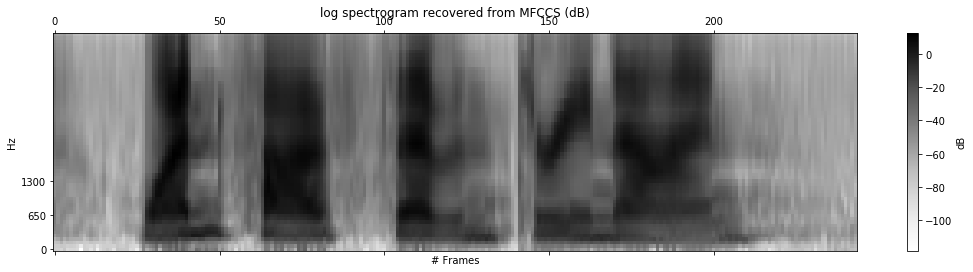

In [98]:
# invert from MFCCs back to waveform
recovered_log_mel_fbank = idct(mfccs, type=2, n=nfilters, axis=1, norm='ortho')

# exponentiate log and invert mel warping
recovered_power = (10**recovered_log_mel_fbank).dot(mel_inv_filter)

# invert mel warping of spectrogram
recovered_magnitude = np.sqrt(recovered_power * size)

# Look at specgram
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(18,4))
cax = ax.matshow(20*np.log10(recovered_magnitude.clip(1e-12)).T, origin='lower', **PLOT_CONFIG)
fig.colorbar(cax, label='dB')
plt.title('log spectrogram recovered from MFCCS (dB)')
plt.xlabel('# Frames')
plt.ylabel('Indices')

# TODO: yticks as frequencies
# ----------------------------
indices = np.arange(0,30,10)
frequencies = np.arange(0,4000,650)
plt.ylabel('Hz')
plt.yticks(indices, frequencies)

In [99]:
recovered_signal = inv_spectrogram(recovered_magnitude, size, step)
Audio(data=recovered_signal, rate=fs)  #(Note: preemphasis is not inverted in resynthesizing the speech)

# Part 2: Single Digit Recognition
-------------------------------------------------
- Use MFCC features along with the Dynamic Time Warping algorithm to perform single digit recognition. This routine uses MFCC features and aligns each test utterance against training templates of each digit to make a prediction.

### TODO:
-----------
- <strong>Finish the implementation of the 'dtw' function below by implementing the recursion step (for computing the minimum distance) and the traceback step to (for finding a minimizing path) which are both <em>marked by TODO</em>. Use the move set introduced in class:</strong>
![Move Set](figures/move_set.png)

In [118]:
size = 256 # window size for the FFT
step = size // 2 # distance to slide along the window in time
nfilters = 40 # number of mel frequency channels
ncoeffs = 13 # number of cepstral coeffecients to keep
mel_filter, _, _ = mel_filterbank(nfilters, size, sample_rate=8000) # mel filters for use below

def dist(a, b):
    """
    Compute the Euclidean distance between a and b.
    --------
    :in:
    a : 1d-array (frame of MFCCs)
    b : 1d-array (frame of MFCCs)
    --------
    :out:
    d, distance between a and b
    """
    d = np.sum((a - b)**2)
    return d

# def dist(a, b,VI):
#     """
#     Compute the Euclidean distance between a and b.
#     --------
#     :in:
#     a : 1d-array (frame of MFCCs)
#     b : 1d-array (frame of MFCCs)
#     --------
#     :out:
#     d, distance between a and b
#     """
#     d = (np.sqrt(np.dot(np.dot((a-b),VI),(a-b).T)))
#     return d




def dtw(x, y, dist):
    """
    Dynamic time warping function.
    Method to compute distance between
    two segments that differ in length.
    --------
    :in:
    x : sequence of MFCC frames (2d-array with shape (Tx, 13)
    y : sequence of MFCC frames (2d-array with shape (Ty, 13)
    dist: function to compute the distance between a frame of x and a frame of y
    --------
    :out:
    d, distance between frame sequences x and y (scalar)
    """ 
#     X = np.vstack([x,y])
#     V = np.cov(X.T)
#     VI = np.linalg.inv(V)
    ######################################
    D = np.zeros((len(x), len(y)))
    for i in range(len(x)):
        for j in range(len(y)):
            D[i, j] = dist(x[i],y[j])
            ##D[i, j] = dist(x[i],y[j],VI)
    
    c = deepcopy(D)
    for i in range(len(x)):
        for j in range(len(y)):
            if i == 0 and j == 0:
                continue
            else:    
                if i == 0:
                    D[i, j] += D[0,j-1]
                    # TODO: edge case
                elif j == 0:
                    D[i, j] += D[i-1,0]
                    # TODO: edge case
                else:
                    D[i, j] += min(D[i-1,j-1],D[i,j-1],D[i-1,j])
                    # TODO: general case/recursive step, min(..., ..., ...)
    i, j = len(x) - 1, len(y) - 1
    x, y = [i], [j]
    while True:
        if i == 0 and j == 0: # then we're done
            break
        else: # figure out which move to traceback
            if i == 0:
                tb = 0 # TODO: edge case
            elif j == 0:
                tb = 1# TODO: edge case
            else:
                tb = 2 # TODO: general case/traceback minimizing path

        # after tracing back the correct move, update the position on the path
        if tb == 0:
            j-=1
            # TODO: update i,j coordinates when tracing back move 0
        elif tb == 1:
            i-=1
            # TODO: update i,j coordinates when tracing back move 1
        else:
            ##print(i,j)
            temp = min([D[i-1,j-1],D[i,j-1],D[i-1,j]])
            if temp == D[i-1,j-1]:
                i-=1
                j-=1
            elif temp == D[i,j-1]:
                j-=1
            else:
                i -=1
            # TODO: update i,j coordinates when tracing back move 2

        x.insert(0, i)
        y.insert(0, j)
    
    path = (x, y)        
    d = D[-1, -1] / np.sum(D.shape)
    return d, path, c

    
def extract_mfcc_features(signal, rate):
    """
    MFCC feature extraction.
    This function is concise representation of the process you started with above.
    This function will be used to extract features from tidgits examples (Downloaded from canvas)
    to perform a simple single digit recognition task.
    --------
    :in:
    signal : array of audio samples
    rate   : sampling rate
    --------
    :return: normalized mfcc features (number of frames, number of cepstral coefficients)
    """
    
    # pre-emphasize signal
    pre_emphasized_signal = pre_emphasis(signal)
    
    # window signal
    frames = windowing(pre_emphasized_signal, size, step) * hamming(size)

    # compute complex spectrum (Note: this produces symmetric output, only need first half)
    spectrum = fast_fourier_transform(frames.T).T
    spectrum = spectrum[:, :size // 2]

    # compute spectrum magnitude (typically what is meant by spectrogram)
    magnitude = np.abs(spectrum)

    # get spectrum power
    power = magnitude**2 / size

    # apply mel warping filters to power spectrum and take log10
    log_mel_fbank = np.log10(power.dot(mel_filter).clip(1e-16))

    # compute MFCCs using discrete cosine transform
    mfccs = dct(log_mel_fbank, type=2, axis=1, norm='ortho')
    
    # keep only first 'ncoeffs' cepstral coefficients
    mfccs = mfccs[:,:ncoeffs]
    
    return mfccs

In [115]:
def single_digit_recognition(num_templates, dist):
    """
    Single digit recognizer.
    Use DTW-distance to a set of training templates per digit
    to predict which digit class each test example belows to.
    ---------
    :in:
    num_templates, number of training templates to compare with
    dist, distance function to be used by DTW (defaults to Euclidean distance)
    ---------
    :out:
    accuracy, overall digit accuracy
    confusion, confusion matrix showing heatmap of digit groundtruth/prediction pairs
    """
    digits = range(10)

    templates = defaultdict(list)
    for digit in digits:
        for i, wav in enumerate(glob('tidigits/train/*/%sa.wav' % ('o' if digit == 0 else str(digit)))):
            if i < num_templates:
                mfccs = extract_mfcc_features(*sf.read(wav))
                templates[digit].append(mfccs)

    accuracy, confusion = np.zeros((10)), np.zeros((10, 10))

    for digit in digits:
        correct, total = 0., 0.
        for wav in glob('tidigits/test/*/%sa.wav' % ('o' if digit == 0 else str(digit))):
            x = extract_mfcc_features(*sf.read(wav))
            comparisons = []
            for i in digits:
                distance = sum([dtw(x, y, dist)[0] for y in templates[i]])
                comparisons.append((i, distance))
            top_digit, _ = sorted(comparisons, key=lambda x: x[1])[0]
            confusion[digit, top_digit] += 1.
        accuracy[digit] = confusion[digit, digit] / confusion[digit].sum()

    return np.mean(accuracy), confusion / confusion.sum(axis=1)

In [120]:
# perform single digit recognition using your dtw function and feature extraction
# Note: this will take about 1 min with the default settings for part 2 above
# --- size = 512
# --- step = size // 2
# --- nfilters = 40
# --- ncoeffs = 13
# If you would like to speed up training you can subsample the sequences of MFCCs
# (e.g. mfccs[::5] to get every fifth frame and cut the length to T/5). Without
# subsampling, the one template example takes ~55s on the speech cube machine.
acc, confusion = single_digit_recognition(num_templates=1, dist=dist)

Text(0.5, 1.05, 'Digit confusion (acc=62.00%)')

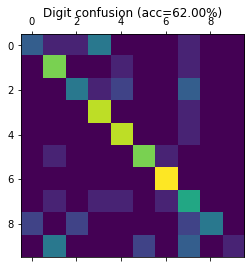

In [117]:
# visualize confusion matrix, mahalanobis distance
plt.matshow(confusion)
plt.title('Digit confusion (acc=%.2f' % (acc * 100.) + '%)')

Text(0.5, 1.05, 'Digit confusion (acc=94.00%)')

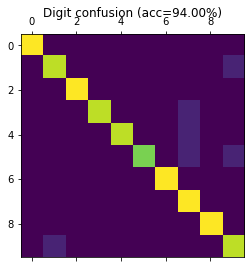

In [121]:
# visualize confusion matrix, Euclidean distance
plt.matshow(confusion)
plt.title('Digit confusion (acc=%.2f' % (acc * 100.) + '%)')

Text(0.5, 1.0, 'Minimum distance: 8.71193700334159')

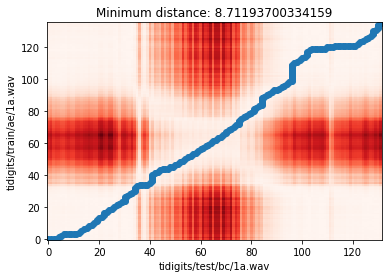

In [130]:
# Visualize the DTW paths for two examples of the same digit class
same_digitA = 'tidigits/test/bc/1a.wav'
same_digitB = 'tidigits/train/ae/1a.wav'
a = extract_mfcc_features(*sf.read(same_digitA))
b = extract_mfcc_features(*sf.read(same_digitB))
min_dist, best_path, cost = dtw(a, b, dist)

plt.imshow(cost.T, origin='lower', cmap=plt.cm.Reds, interpolation='nearest', aspect='auto')
plt.plot(best_path[0], best_path[1], '-o')
plt.xlabel(same_digitA)
plt.ylabel(same_digitB)
plt.axis('tight')
plt.title('Minimum distance: {}'.format(min_dist))

Text(0.5, 1.0, 'Minimum distance: 52.9242474114175')

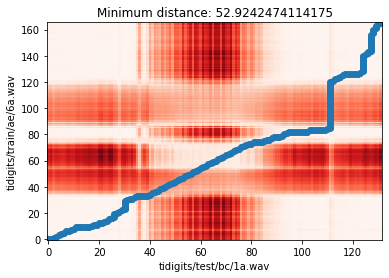

In [131]:
# Visualize the DTW paths for two examples of different digit classes
diff_digitA = 'tidigits/test/bc/1a.wav'
diff_digitB = 'tidigits/train/ae/6a.wav'
a = extract_mfcc_features(*sf.read(diff_digitA))
b = extract_mfcc_features(*sf.read(diff_digitB))
min_dist, best_path, cost = dtw(a, b, dist)

plt.imshow(cost.T, origin='lower', cmap=plt.cm.Reds, interpolation='nearest', aspect='auto')
plt.plot(best_path[0], best_path[1], '-o')
plt.xlabel(diff_digitA)
plt.ylabel(diff_digitB)
plt.axis('tight')
plt.title('Minimum distance: {}'.format(min_dist))

In [ ]:
np.cov()